In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


# Imports

In [2]:
# Import necessary packages
import os 
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
import albumentations as A
from albumentations.pytorch import ToTensor
from torch.types import Number
import sys
from torch.utils.data import DataLoader
import torch.optim as optim
from tqdm import tqdm
from torchvision.utils import save_image
import albumentations as A

# Constant Variables

In [3]:
GROUND_PATH = "/content/drive/MyDrive/Courses/York Courses/Neural Networks and Deep Learning/Project/DataSet/testA"
SEGMENT_PATH = "/content/drive/MyDrive/Courses/York Courses/Neural Networks and Deep Learning/Project/DataSet/testB"

GROUND_PATH_TEST = "/content/drive/MyDrive/Courses/York Courses/Neural Networks and Deep Learning/Project/DataSet/testA"
SEGMENT_PATH_TEST = "/content/drive/MyDrive/Courses/York Courses/Neural Networks and Deep Learning/Project/DataSet/testB"


DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
LEARNING_RATE = 1e-5
LAMBDA_IDENTITY = 10.0
LAMBDA_CYCLE = 10
WEIGHTS_GEN_G = "/content/drive/MyDrive/Courses/York Courses/Neural Networks and Deep Learning/Project/Weights/GEN_G"
WEIGHTS_GEN_S = "/content/drive/MyDrive/Courses/York Courses/Neural Networks and Deep Learning/Project/Weights/GEN_S"
WEIGHTS_DISC_G = "/content/drive/MyDrive/Courses/York Courses/Neural Networks and Deep Learning/Project/Weights/DISC_G"
WEIGHTS_DISC_S = "/content/drive/MyDrive/Courses/York Courses/Neural Networks and Deep Learning/Project/Weights/DISC_S"
SAVE_IMAGE = "/content/drive/MyDrive/Courses/York Courses/Neural Networks and Deep Learning/Project/Images"


transforms = A.Compose(
    [
        A.Resize(width=256, height=256),
        A.HorizontalFlip(p=0.5),
        A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5], max_pixel_value=255),
        ToTensor(),
     ],
    additional_targets={"image": "image",
                        'image1': 'image',},
)

transforms2 = A.Compose(
    [
        A.Resize(width=256, height=256),
        ToTensor(),
     ],
)
BATCH_SIZE = 1
NUM_WORKERS = 4
NUM_EPOCHS = 1000

In [4]:
NUM_EPOCHS = 1000

# Functions

In [5]:


def save_checkpoint(model, optimizer, filename="my_checkpoint.pth.tar"):
    print("=> Saving checkpoint")
    checkpoint = {
        "state_dict": model.state_dict(),
        "optimizer": optimizer.state_dict(),
    }
    torch.save(checkpoint, filename)



# DataSet

In [6]:

class CityscapesDataSet(Dataset):
    def __init__(self, SegmentationPath, GroundImagePath, transform=None):
        self.GroundImagePath = GroundImagePath
        self.SegmentationPath = SegmentationPath
        self.transform = transform

        self.GroundImages = os.listdir(GroundImagePath)
        self.SegmentImages = os.listdir(SegmentationPath)
        self.length_dataset = max(len(self.GroundImages), len(self.SegmentImages)) 
        self.Gr_len = len(self.GroundImages)
        self.Sg_len = len(self.SegmentImages)

    def __len__(self):
        return self.length_dataset

    def __getitem__(self, index):
        Ground = self.GroundImages[index % self.Gr_len]
        Segment = self.SegmentImages[index % self.Sg_len]


        Ground = np.array(Image.open(os.path.join(self.GroundImagePath, Ground)).convert("RGB"))
        Segment = np.array(Image.open(os.path.join(self.SegmentationPath, Segment)).convert("RGB"))

        if self.transform:
            Ground = self.transform(image=Ground)
            Segment = self.transform(image=Segment)
            Ground = Ground['image']
            Segment = Segment['image']

        return Segment, Ground

# Generator

In [7]:
class ConvBlock(nn.Module):
    def __init__(self, in_channel, out_channel, kernel_size, padding, down=True, use_act=True, **kwargs):
        super().__init__()
        if down:
          self.conv1 = nn.Conv2d(in_channel, out_channel, padding_mode="reflect", kernel_size=kernel_size, padding=padding, **kwargs)
        else:
          self.conv1 = nn.ConvTranspose2d(in_channel, out_channel, kernel_size=kernel_size, padding=padding, **kwargs)
        self.IN = nn.InstanceNorm2d(out_channel)
        if use_act:
          self.acv = nn.ReLU(inplace=True)
        else:
          self.acv = nn.Identity()
    def forward(self, x):
      x = self.conv1(x)
      x = self.IN(x)
      return  self.acv(x)

In [8]:
class ResBlock(nn.Module):
  def __init__(self, channels):
    super().__init__()
    self.Conv1 = ConvBlock(channels, channels, kernel_size=3, padding=1)
    self.Conv2 = ConvBlock(channels, channels, kernel_size=3, padding=1, use_act=False)
  
  def forward(self, x):
    x2 = self.Conv1(x)
    x2 = self.Conv2(x2)
    return x + x2

In [9]:

class Generator(nn.Module):
  def __init__(self, img_channels, num_features=64, num_residual=9):
    super().__init__()
    self.conv1 = nn.Conv2d(img_channels, num_features, kernel_size=7, stride=1, padding=3, padding_mode="reflect")
    self.acv1 = nn.ReLU(inplace=True)

    self.DownBlock = nn.ModuleList([
        nn.Conv2d(num_features, num_features*2, kernel_size=3, stride=2, padding=1),
        nn.Conv2d(num_features*2, num_features*4, kernel_size=3, stride=2, padding=1),
    ])

    self.residual_blocks = nn.Sequential(
        *[ResBlock(num_features*4) for _ in range(num_residual)]
    )

    self.up_blocks = nn.ModuleList([
        ConvBlock(num_features*4, num_features*2, kernel_size=3, stride=2, padding=1, output_padding=1, down=False),
        ConvBlock(num_features*2, num_features*1, kernel_size=3, stride=2, padding=1, output_padding=1, down=False),
    ])

    self.last_layer = nn.Conv2d(num_features, img_channels, kernel_size=7, stride=1, padding=3, padding_mode="reflect")

  def forward(self, x):
    x = self.conv1(x)
    x = self.acv1(x)
    for layer in self.DownBlock:
      x = layer(x)

    for layer in self.up_blocks:
      x = layer(x)
    return torch.tanh(self.last_layer(x))
    


# Discriminator

In [10]:
class DiscBlock(nn.Module):
  def __init__(self, in_channel, out_channel, stride):
    super().__init__()
    self.conv1 = nn.Conv2d(in_channel, out_channel, 4, stride, 1, bias=True, padding_mode="reflect")
    self.IN1 = nn.InstanceNorm2d(out_channel)
    self.act1 = nn.LeakyReLU(0.2)
  def forward(self, x):
    x = self.conv1(x)
    x = self.IN1(x)
    x = self.act1(x)
    return x

In [11]:
class Discriminator(nn.Module):
  def __init__(self, in_channel, num_features=[64, 128, 256, 512]):
    super().__init__()
    self.conv1 = nn.Conv2d(in_channel, num_features[0], kernel_size=4, stride=2, padding=1, padding_mode="reflect")
    self.act1 = nn.LeakyReLU(0.2)

    layers = []
    in_channel = num_features[0]
    
    for counter in range(1,len(num_features)):

      layers.append(DiscBlock(in_channel, num_features[counter], stride=1 if counter==(len(num_features)-1) else 2))
      in_channel = num_features[counter]
    layers.append(nn.Conv2d(in_channel, 1, kernel_size=4, stride=1, padding=1, padding_mode="reflect"))
    self.model = nn.Sequential(*layers)


  def forward(self, x):
    x = self.conv1(x)
    x = self.act1(x)
    x = self.model(x)
    return torch.sigmoid(x)

   

# Train

In [12]:
def TrainCicleGAN(Disc_Ground, Gen_Seg, Disc_Seg, Gen_Ground, loader, optim_Disc, optim_Gen, L1, MSE, Disc_scaler, Gen_scaler):
  H_reals = 0
  H_fakes = 0
  D_Z_real_loss_list = 0
  D_Z_fake_loss_list = 0
  cycle_segm_loss_list = 0
  cycle_ground_loss_list = 0
  loss_G_Z_list = 0
  loss_G_H_list = 0
  identity_segm_loss_list = 0
  identity_ground_loss_list = 0
  loop_prop = tqdm(loader, leave=True)
  index2 = 0
  for index, (segm, grd) in enumerate(loop_prop):
    grd = grd.to(DEVICE)
    segm = segm.to(DEVICE)
    
    
    with torch.cuda.amp.autocast():
        fake_ground = Gen_Ground(segm)
        D_H_real = Disc_Ground(grd)
        D_H_fake = Disc_Ground(fake_ground.detach())
        H_reals += D_H_real.mean().item()
        H_fakes += D_H_fake.mean().item()
        D_H_real_loss = MSE(D_H_real, torch.ones_like(D_H_real))
        D_H_fake_loss = MSE(D_H_fake, torch.zeros_like(D_H_fake))
        D_H_loss = D_H_real_loss + D_H_fake_loss
       
        fake_seg = Gen_Seg(grd)
        D_Z_real = Disc_Seg(segm)
        D_Z_fake = Disc_Seg(fake_seg.detach())
        D_Z_real_loss = MSE(D_Z_real, torch.ones_like(D_Z_real))
        D_Z_fake_loss = MSE(D_Z_fake, torch.zeros_like(D_Z_fake))
        D_Z_loss = D_Z_real_loss + D_Z_fake_loss
        D_Z_real_loss_list += D_Z_real_loss
        D_Z_fake_loss_list += (D_Z_fake_loss)
        
        
        D_loss = (D_H_loss + D_Z_loss)/2

    optim_Disc.zero_grad()
    Disc_scaler.scale(D_loss).backward()
    Disc_scaler.step(optim_Disc)
    Disc_scaler.update()

    # Train Generators H and Z
    with torch.cuda.amp.autocast():
        # adversarial loss for both generators
        D_H_fake = Disc_Ground(fake_ground)
        D_Z_fake = Disc_Seg(fake_seg)
        loss_G_H = MSE(D_H_fake, torch.ones_like(D_H_fake))
        loss_G_Z = MSE(D_Z_fake, torch.ones_like(D_Z_fake))
        loss_G_Z_list += (loss_G_H)
        loss_G_H_list += (loss_G_Z)
        # cycle loss
        cycle_segm = Gen_Seg(fake_ground)
        cycle_ground = Gen_Ground(fake_seg)
        cycle_segm_loss = L1(segm, cycle_segm)
        cycle_ground_loss = L1(grd, cycle_ground)
        cycle_segm_loss_list += (cycle_segm_loss)
        cycle_ground_loss_list += (cycle_ground_loss)   

        # identity loss (remove these for efficiency if you set lambda_identity=0)
        identity_segm = Gen_Seg(segm)
        identity_ground = Gen_Ground(grd)
        identity_segm_loss = L1(segm, identity_segm)
        identity_ground_loss = L1(grd, identity_ground)
        identity_segm_loss_list += (identity_segm_loss)
        identity_ground_loss_list += (identity_ground_loss)
        # add all togethor
        G_loss = (
            loss_G_Z
            + loss_G_H
            + cycle_segm_loss * LAMBDA_CYCLE
            + cycle_ground_loss * LAMBDA_CYCLE
            + identity_ground_loss * LAMBDA_IDENTITY
            + identity_segm_loss * LAMBDA_IDENTITY
        )

    optim_Gen.zero_grad()
    Gen_scaler.scale(G_loss).backward()
    Gen_scaler.step(optim_Gen)
    Gen_scaler.update()

    if index2 % 200 == 0:
        save_image(fake_ground, SAVE_IMAGE + f"/Ground/{index2}.png")
        save_image(fake_seg, SAVE_IMAGE + f"/Segment/{index2}.png")
    index2 += 1
    loop_prop.set_postfix(H_real=H_reals/(index+1), H_fake=H_fakes/(index+1))
  return (D_Z_real_loss_list), (D_Z_fake_loss), (cycle_segm_loss_list), (cycle_ground_loss_list), (loss_G_Z_list), (loss_G_H_list),(identity_segm_loss_list), (identity_ground_loss_list)


# Main Function

In [13]:

LOAD_MODEL=False
SAVE_MODEL=False


Disc_Ground = Discriminator(in_channel=3).to(DEVICE)
Disc_Seg = Discriminator(in_channel=3).to(DEVICE)
Gen_Ground = Generator(img_channels=3, num_residual=9).to(DEVICE)
Gen_Seg = Generator(img_channels=3, num_residual=9).to(DEVICE)





optim_Disc = optim.Adam(list(Disc_Ground.parameters()) + list(Disc_Seg.parameters()), lr=LEARNING_RATE, betas=(0.5, 0.999),)
optim_Gen = optim.Adam(list(Disc_Ground.parameters()) + list(Gen_Seg.parameters()), lr=LEARNING_RATE, betas=(0.5, 0.999),)

L1 = nn.L1Loss()
MSE = nn.MSELoss()
if LOAD_MODEL:

  Disc_Ground.load_state_dict(torch.load(WEIGHTS_DISC_G))
  Disc_Seg.load_state_dict(torch.load(WEIGHTS_DISC_S))
  Gen_Ground.load_state_dict(torch.load(WEIGHTS_GEN_G))
  Gen_Seg.load_state_dict(torch.load(WEIGHTS_GEN_S))
dataset = CityscapesDataSet(SEGMENT_PATH, GROUND_PATH, transforms2)
test_dataset = CityscapesDataSet(SEGMENT_PATH_TEST, GROUND_PATH_TEST, transforms2)

loader = DataLoader(
    dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=True
)


test_loader = DataLoader(
  test_dataset,
  batch_size=1,
  shuffle=False,
  pin_memory=True,
)

Gen_scaler = torch.cuda.amp.GradScaler()
Disc_scaler = torch.cuda.amp.GradScaler()
x1_list = []
x2_list = []
x3_list = []
x4_list = []
x5_list = []
x6_list = []
x7_list = []
x8_list = []


for epoch in range(NUM_EPOCHS):
    x1,x2,x3,x4,x5,x6,x7,x8 = TrainCicleGAN(Disc_Ground, Gen_Seg, Disc_Seg, Gen_Ground, loader, optim_Disc, optim_Gen, L1, MSE, Disc_scaler, Gen_scaler)

    x1_list.append(x1)
    x2_list.append(x2)
    x3_list.append(x3)
    x4_list.append(x4)
    x5_list.append(x5)
    x6_list.append(x6)
    x7_list.append(x7)
    x8_list.append(x8)
    if SAVE_MODEL:
      torch.save(Disc_Ground.state_dict(), WEIGHTS_DISC_G)
      torch.save(Disc_Seg.state_dict(), WEIGHTS_DISC_S)

      torch.save(Gen_Ground.state_dict(), WEIGHTS_GEN_G)
      torch.save(Gen_Seg.state_dict(), WEIGHTS_GEN_S)



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
  0%|          | 2/500 [00:03<13:30,  1.63s/it, H_fake=0.65, H_real=0.718]


KeyboardInterrupt: ignored

In [ ]:

LOAD_MODEL=True
SAVE_MODEL=True


Disc_Ground = Discriminator(in_channel=3).to(DEVICE)
Disc_Seg = Discriminator(in_channel=3).to(DEVICE)
Gen_Ground = Generator(img_channels=3, num_residual=9).to(DEVICE)
Gen_Seg = Generator(img_channels=3, num_residual=9).to(DEVICE)





optim_Disc = optim.Adam(list(Disc_Ground.parameters()) + list(Disc_Seg.parameters()), lr=LEARNING_RATE, betas=(0.5, 0.999),)
optim_Gen = optim.Adam(list(Disc_Ground.parameters()) + list(Gen_Seg.parameters()), lr=LEARNING_RATE, betas=(0.5, 0.999),)

L1 = nn.L1Loss()
MSE = nn.MSELoss()
if LOAD_MODEL:

  Disc_Ground.load_state_dict(torch.load(WEIGHTS_DISC_G))
  Disc_Seg.load_state_dict(torch.load(WEIGHTS_DISC_S))
  Gen_Ground.load_state_dict(torch.load(WEIGHTS_GEN_G))
  Gen_Seg.load_state_dict(torch.load(WEIGHTS_GEN_S))
    # load_checkpoint(
    #     WEIGHTS_GEN_G, Gen_Ground, optim_Gen, LEARNING_RATE,
    # )
    # load_checkpoint(
    #     WEIGHTS_GEN_S, Gen_Seg, optim_Gen, LEARNING_RATE,
    # )
    # load_checkpoint(
    #     WEIGHTS_DISC_G, Disc_Ground, optim_Disc, LEARNING_RATE,
    # )
    # load_checkpoint(
    #     WEIGHTS_DISC_S, Disc_Seg, optim_Disc, LEARNING_RATE,
    # )
dataset = CityscapesDataSet(SEGMENT_PATH, GROUND_PATH, transforms2)
test_dataset = CityscapesDataSet(SEGMENT_PATH_TEST, GROUND_PATH_TEST, transforms2)

loader = DataLoader(
    dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=True
)


test_loader = DataLoader(
  test_dataset,
  batch_size=1,
  shuffle=False,
  pin_memory=True,
)

Gen_scaler = torch.cuda.amp.GradScaler()
Disc_scaler = torch.cuda.amp.GradScaler()

for epoch in range(NUM_EPOCHS):
    TrainCicleGAN(Disc_Ground, Gen_Seg, Disc_Seg, Gen_Ground, loader, optim_Disc, optim_Gen, L1, MSE, Disc_scaler, Gen_scaler)


    if SAVE_MODEL:
      torch.save(Disc_Ground.state_dict(), WEIGHTS_DISC_G)
      torch.save(Disc_Seg.state_dict(), WEIGHTS_DISC_S)

      torch.save(Gen_Ground.state_dict(), WEIGHTS_GEN_G)
      torch.save(Gen_Seg.state_dict(), WEIGHTS_GEN_S)




/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
100%|██████████| 500/500 [00:53<00:00,  9.31it/s, H_fake=0.788, H_real=0.851]


In [ ]:

LOAD_MODEL=True
SAVE_MODEL=True


Disc_Ground = Discriminator(in_channel=3).to(DEVICE)
Disc_Seg = Discriminator(in_channel=3).to(DEVICE)
Gen_Ground = Generator(img_channels=3, num_residual=9).to(DEVICE)
Gen_Seg = Generator(img_channels=3, num_residual=9).to(DEVICE)





optim_Disc = optim.Adam(list(Disc_Ground.parameters()) + list(Disc_Seg.parameters()), lr=LEARNING_RATE, betas=(0.5, 0.999),)
optim_Gen = optim.Adam(list(Disc_Ground.parameters()) + list(Gen_Seg.parameters()), lr=LEARNING_RATE, betas=(0.5, 0.999),)

L1 = nn.L1Loss()
MSE = nn.MSELoss()
if LOAD_MODEL:

  Disc_Ground.load_state_dict(torch.load(WEIGHTS_DISC_G))
  Disc_Seg.load_state_dict(torch.load(WEIGHTS_DISC_S))
  Gen_Ground.load_state_dict(torch.load(WEIGHTS_GEN_G))
  Gen_Seg.load_state_dict(torch.load(WEIGHTS_GEN_S))
    # load_checkpoint(
    #     WEIGHTS_GEN_G, Gen_Ground, optim_Gen, LEARNING_RATE,
    # )
    # load_checkpoint(
    #     WEIGHTS_GEN_S, Gen_Seg, optim_Gen, LEARNING_RATE,
    # )
    # load_checkpoint(
    #     WEIGHTS_DISC_G, Disc_Ground, optim_Disc, LEARNING_RATE,
    # )
    # load_checkpoint(
    #     WEIGHTS_DISC_S, Disc_Seg, optim_Disc, LEARNING_RATE,
    # )
dataset = CityscapesDataSet(SEGMENT_PATH, GROUND_PATH, transforms2)
test_dataset = CityscapesDataSet(SEGMENT_PATH_TEST, GROUND_PATH_TEST, transforms2)

loader = DataLoader(
    dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=True
)


test_loader = DataLoader(
  test_dataset,
  batch_size=1,
  shuffle=False,
  pin_memory=True,
)

Gen_scaler = torch.cuda.amp.GradScaler()
Disc_scaler = torch.cuda.amp.GradScaler()

for epoch in range(NUM_EPOCHS):
    TrainCicleGAN(Disc_Ground, Gen_Seg, Disc_Seg, Gen_Ground, loader, optim_Disc, optim_Gen, L1, MSE, Disc_scaler, Gen_scaler)


    if SAVE_MODEL:
      torch.save(Disc_Ground.state_dict(), WEIGHTS_DISC_G)
      torch.save(Disc_Seg.state_dict(), WEIGHTS_DISC_S)

      torch.save(Gen_Ground.state_dict(), WEIGHTS_GEN_G)
      torch.save(Gen_Seg.state_dict(), WEIGHTS_GEN_S)




/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
100%|██████████| 500/500 [00:54<00:00,  9.22it/s, H_fake=0.803, H_real=0.854]


In [ ]:

LOAD_MODEL=True
SAVE_MODEL=True


Disc_Ground = Discriminator(in_channel=3).to(DEVICE)
Disc_Seg = Discriminator(in_channel=3).to(DEVICE)
Gen_Ground = Generator(img_channels=3, num_residual=9).to(DEVICE)
Gen_Seg = Generator(img_channels=3, num_residual=9).to(DEVICE)





optim_Disc = optim.Adam(list(Disc_Ground.parameters()) + list(Disc_Seg.parameters()), lr=LEARNING_RATE, betas=(0.5, 0.999),)
optim_Gen = optim.Adam(list(Disc_Ground.parameters()) + list(Gen_Seg.parameters()), lr=LEARNING_RATE, betas=(0.5, 0.999),)

L1 = nn.L1Loss()
MSE = nn.MSELoss()
if LOAD_MODEL:

  Disc_Ground.load_state_dict(torch.load(WEIGHTS_DISC_G))
  Disc_Seg.load_state_dict(torch.load(WEIGHTS_DISC_S))
  Gen_Ground.load_state_dict(torch.load(WEIGHTS_GEN_G))
  Gen_Seg.load_state_dict(torch.load(WEIGHTS_GEN_S))
    # load_checkpoint(
    #     WEIGHTS_GEN_G, Gen_Ground, optim_Gen, LEARNING_RATE,
    # )
    # load_checkpoint(
    #     WEIGHTS_GEN_S, Gen_Seg, optim_Gen, LEARNING_RATE,
    # )
    # load_checkpoint(
    #     WEIGHTS_DISC_G, Disc_Ground, optim_Disc, LEARNING_RATE,
    # )
    # load_checkpoint(
    #     WEIGHTS_DISC_S, Disc_Seg, optim_Disc, LEARNING_RATE,
    # )
dataset = CityscapesDataSet(SEGMENT_PATH, GROUND_PATH, transforms2)
test_dataset = CityscapesDataSet(SEGMENT_PATH_TEST, GROUND_PATH_TEST, transforms2)

loader = DataLoader(
    dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=True
)


test_loader = DataLoader(
  test_dataset,
  batch_size=1,
  shuffle=False,
  pin_memory=True,
)

Gen_scaler = torch.cuda.amp.GradScaler()
Disc_scaler = torch.cuda.amp.GradScaler()

for epoch in range(NUM_EPOCHS):
    TrainCicleGAN(Disc_Ground, Gen_Seg, Disc_Seg, Gen_Ground, loader, optim_Disc, optim_Gen, L1, MSE, Disc_scaler, Gen_scaler)


    if SAVE_MODEL:
      torch.save(Disc_Ground.state_dict(), WEIGHTS_DISC_G)
      torch.save(Disc_Seg.state_dict(), WEIGHTS_DISC_S)

      torch.save(Gen_Ground.state_dict(), WEIGHTS_GEN_G)
      torch.save(Gen_Seg.state_dict(), WEIGHTS_GEN_S)




/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
 18%|█▊        | 89/500 [00:10<00:44,  9.15it/s, H_fake=0.804, H_real=0.845]

In [ ]:

LOAD_MODEL=True
SAVE_MODEL=True


Disc_Ground = Discriminator(in_channel=3).to(DEVICE)
Disc_Seg = Discriminator(in_channel=3).to(DEVICE)
Gen_Ground = Generator(img_channels=3, num_residual=9).to(DEVICE)
Gen_Seg = Generator(img_channels=3, num_residual=9).to(DEVICE)





optim_Disc = optim.Adam(list(Disc_Ground.parameters()) + list(Disc_Seg.parameters()), lr=LEARNING_RATE, betas=(0.5, 0.999),)
optim_Gen = optim.Adam(list(Disc_Ground.parameters()) + list(Gen_Seg.parameters()), lr=LEARNING_RATE, betas=(0.5, 0.999),)

L1 = nn.L1Loss()
MSE = nn.MSELoss()
if LOAD_MODEL:

  Disc_Ground.load_state_dict(torch.load(WEIGHTS_DISC_G))
  Disc_Seg.load_state_dict(torch.load(WEIGHTS_DISC_S))
  Gen_Ground.load_state_dict(torch.load(WEIGHTS_GEN_G))
  Gen_Seg.load_state_dict(torch.load(WEIGHTS_GEN_S))
    # load_checkpoint(
    #     WEIGHTS_GEN_G, Gen_Ground, optim_Gen, LEARNING_RATE,
    # )
    # load_checkpoint(
    #     WEIGHTS_GEN_S, Gen_Seg, optim_Gen, LEARNING_RATE,
    # )
    # load_checkpoint(
    #     WEIGHTS_DISC_G, Disc_Ground, optim_Disc, LEARNING_RATE,
    # )
    # load_checkpoint(
    #     WEIGHTS_DISC_S, Disc_Seg, optim_Disc, LEARNING_RATE,
    # )
dataset = CityscapesDataSet(SEGMENT_PATH, GROUND_PATH, transforms2)
test_dataset = CityscapesDataSet(SEGMENT_PATH_TEST, GROUND_PATH_TEST, transforms2)

loader = DataLoader(
    dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=True
)


test_loader = DataLoader(
  test_dataset,
  batch_size=1,
  shuffle=False,
  pin_memory=True,
)

Gen_scaler = torch.cuda.amp.GradScaler()
Disc_scaler = torch.cuda.amp.GradScaler()

for epoch in range(NUM_EPOCHS):
    TrainCicleGAN(Disc_Ground, Gen_Seg, Disc_Seg, Gen_Ground, loader, optim_Disc, optim_Gen, L1, MSE, Disc_scaler, Gen_scaler)


    if SAVE_MODEL:
      torch.save(Disc_Ground.state_dict(), WEIGHTS_DISC_G)
      torch.save(Disc_Seg.state_dict(), WEIGHTS_DISC_S)

      torch.save(Gen_Ground.state_dict(), WEIGHTS_GEN_G)
      torch.save(Gen_Seg.state_dict(), WEIGHTS_GEN_S)



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
 95%|█████████▌| 477/500 [08:19<00:24,  1.05s/it, H_fake=0.805, H_real=0.835]

In [22]:
x_len = np.linspace(0, 66, len(x1_list))

In [ ]:
x1_list

[tensor(33.4409, device='cuda:0', grad_fn=<AddBackward0>),
 tensor(4.8671, device='cuda:0', grad_fn=<AddBackward0>),
 tensor(1.6431, device='cuda:0', grad_fn=<AddBackward0>),
 tensor(0.7270, device='cuda:0', grad_fn=<AddBackward0>),
 tensor(0.3908, device='cuda:0', grad_fn=<AddBackward0>),
 tensor(0.2232, device='cuda:0', grad_fn=<AddBackward0>),
 tensor(0.1481, device='cuda:0', grad_fn=<AddBackward0>),
 tensor(0.0967, device='cuda:0', grad_fn=<AddBackward0>),
 tensor(0.0600, device='cuda:0', grad_fn=<AddBackward0>),
 tensor(0.0410, device='cuda:0', grad_fn=<AddBackward0>),
 tensor(0.0280, device='cuda:0', grad_fn=<AddBackward0>),
 tensor(0.0209, device='cuda:0', grad_fn=<AddBackward0>),
 tensor(0.0169, device='cuda:0', grad_fn=<AddBackward0>),
 tensor(0.0108, device='cuda:0', grad_fn=<AddBackward0>),
 tensor(0.0086, device='cuda:0', grad_fn=<AddBackward0>),
 tensor(0.0073, device='cuda:0', grad_fn=<AddBackward0>),
 tensor(0.0051, device='cuda:0', grad_fn=<AddBackward0>),
 tensor(0.003

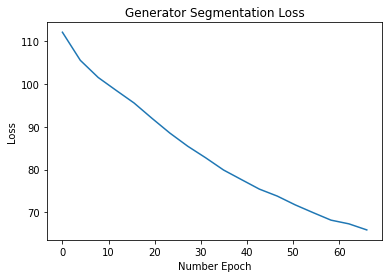

In [38]:
plt.title("Generator Segmentation Loss") 
plt.xlabel("Number Epoch") 
plt.ylabel("Loss") 
plt.plot(x_len, new5)
plt.show()

(D_Z_real_loss_list), (D_Z_fake_loss), (cycle_segm_loss_list), (cycle_ground_loss_list), (loss_G_Z_list), (loss_G_H_list),(identity_segm_loss_list), (identity_ground_loss_list)

In [14]:
new1 = []
new2 = []
new3 = []
new4 = []
new5 = []
new6 = []
new7 = []
new8 = []

for i in range(len(x1_list)):
  new1.append(x1_list[i].cpu().detach().numpy())
  new2.append(x2_list[i].cpu().detach().numpy())
  new3.append(x3_list[i].cpu().detach().numpy())
  new4.append(x4_list[i].cpu().detach().numpy())
  new5.append(x5_list[i].cpu().detach().numpy())
  new6.append(x6_list[i].cpu().detach().numpy())
  new7.append(x7_list[i].cpu().detach().numpy())
  new8.append(x8_list[i].cpu().detach().numpy())
  

new1 = np.array(new1)
new2 = np.array(new2)
new3 = np.array(new3)
new4 = np.array(new4)
new5 = np.array(new5)
new6 = np.array(new6)
new7 = np.array(new7)
new8 = np.array(new8)

(D_Z_real_loss_list), (D_Z_fake_loss), (cycle_segm_loss_list), (cycle_ground_loss_list), (loss_G_Z_list), (loss_G_H_list),(identity_segm_loss_list), (identity_ground_loss_list)

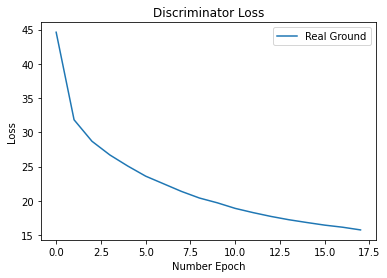

In [21]:
plt.title("Discriminator Loss") 
plt.xlabel("Number Epoch") 
plt.ylabel("Loss") 
plt.plot(new3, label="Real Ground")
#plt.plot(new2, label="Segmentation")
plt.legend()
plt.show()

In [ ]:
new2

array([3.54105011e-02, 4.57666349e-03, 3.40478215e-03, 1.12541733e-04,
       2.15583583e-04, 4.41333599e-04, 1.02819991e-04, 1.03252183e-04,
       9.33382489e-06, 3.00980537e-05, 1.32701780e-05, 2.77748841e-05,
       1.53940218e-05, 2.66360130e-05, 8.46544845e-06, 2.80548352e-06,
       4.08518645e-06, 1.86857251e-05, 3.27111661e-06, 1.25777285e-06,
       1.12930320e-05, 4.42793976e-07, 9.78598791e-07, 8.28583495e-07,
       5.31779619e-07, 5.45947103e-07, 2.15029999e-07, 2.92127595e-07,
       1.84936511e-07, 2.99941632e-07, 1.36395244e-07, 1.09754687e-07,
       1.11714584e-07, 3.38766455e-08, 1.09790562e-07, 4.65477541e-08,
       8.76926549e-08, 1.80723916e-08, 2.37298323e-08, 1.36285854e-08,
       5.58822766e-09, 2.71575940e-09, 1.70424492e-08, 5.26994670e-09,
       3.41625883e-09, 3.65827546e-09, 6.10024475e-09, 3.09947201e-09,
       2.18254081e-09, 1.44272183e-09, 3.06984727e-09, 2.06259720e-09,
       1.21147536e-09, 1.27698208e-09, 1.61898905e-09, 2.81601797e-10,
      